## 90% accuracy on CIFAR-10 using Keras and Tensorflow

In this project I'm trying to recreate the network introduced in [this article](https://arxiv.org/pdf/1412.6806.pdf) and get 90% accuracy on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

Importing all the dependancies

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import helper

# Keras dependancies
import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
model_path = 'models/'

import os
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [3]:
checkpoint = ModelCheckpoint(model_path+'best_model.h5',
                             monitor='val_loss', # check for validation loss
                             verbose=0,
                             save_best_only= True,
                             mode='auto')

### Importing MNIST dataset:

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("MNIST shapes")
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)

MNIST shapes
x_train : (50000, 32, 32, 3)
y_train : (50000, 1)
x_test  : (10000, 32, 32, 3)
y_test  : (10000, 1)


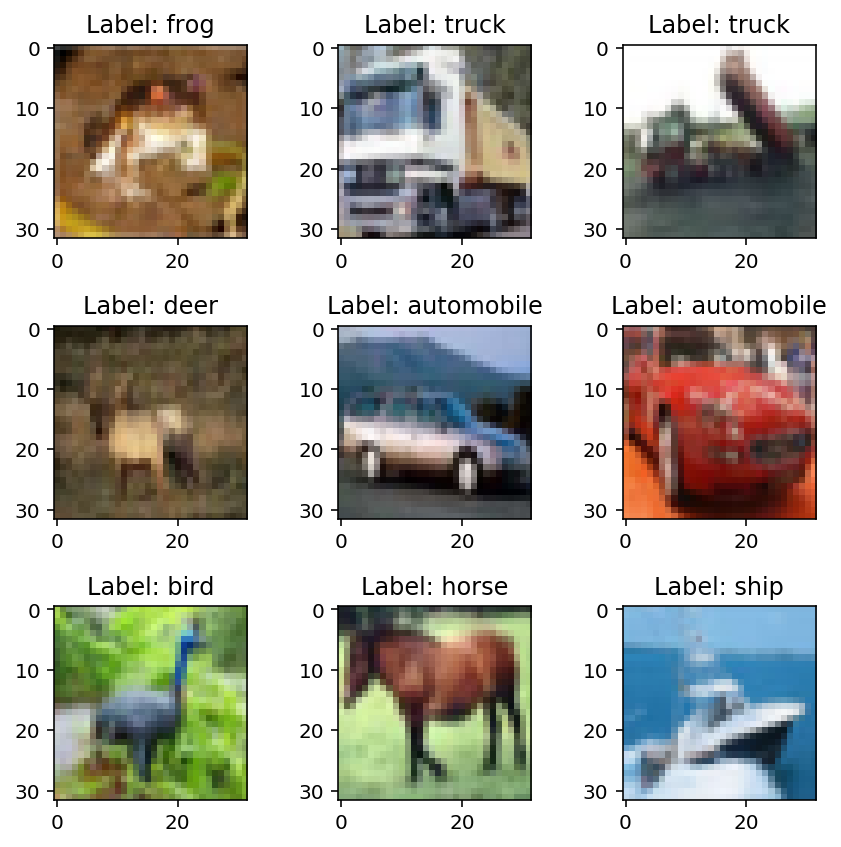

In [5]:
helper.display_nine_examples(x_train, y_train)

In [6]:
# preserving old shape
y_val_train = y_train
y_val_test = y_test
# reshaping for TensorFlow - 1 dimension for greyscale, 3 for RGB
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)
print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)  

x_train : (50000, 32, 32, 3)
x_test  : (10000, 32, 32, 3)


In [7]:
# Before one-hot
y_train[0:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

### [One-hot encoding](https://en.wikipedia.org/wiki/One-hot) the dataset:

In [8]:
# One-hot encoding labels for the softmax output layer
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
# After one-hot
y_train[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [10]:
# Input normalization
mean = x_train.mean().astype(np.float32)
std_dev = x_train.std().astype(np.float32)

def normalize_input(x): 
    return (x - mean) / std_dev

### Simple linear model using for testing (orders of magnitude faster than the final model):

In [11]:
def get_linear_model():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(32,32,3)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### All-CNN-C:

The network implemented from [This paper](https://arxiv.org/pdf/1412.6806.pdf)

In [12]:
def get_all_cnn():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(32,32,3)))
    model.add(Conv2D(96,(3,3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(96,(3,3), activation='relu'))
    model.add(Conv2D(96,(3,3), activation='relu', strides = 2))
    model.add(Dropout(0.5))
    model.add(Conv2D(192,(3,3), activation='relu'))
    model.add(Conv2D(192,(3,3), activation='relu'))
    model.add(Conv2D(192,(3,3), activation='relu', strides = 2))
    model.add(Dropout(0.5))
    model.add(Conv2D(192,(3,3), activation='relu'))
    model.add(Conv2D(192,(1,1), activation='relu'))
    model.add(Conv2D(10,(1,1)))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    model.compile(Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
# model = get_linear_model() # simple model used for testing
model = get_all_cnn()

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 96)        2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 192)       166080    
__________

In [15]:
# Data augmentation to prevent overfitting
gen = image.ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.15, 
                               shear_range=0.15,
                               height_shift_range=0.15, 
                               zoom_range=0.15, 
                               horizontal_flip=True,)

### Visualising data augmentation:

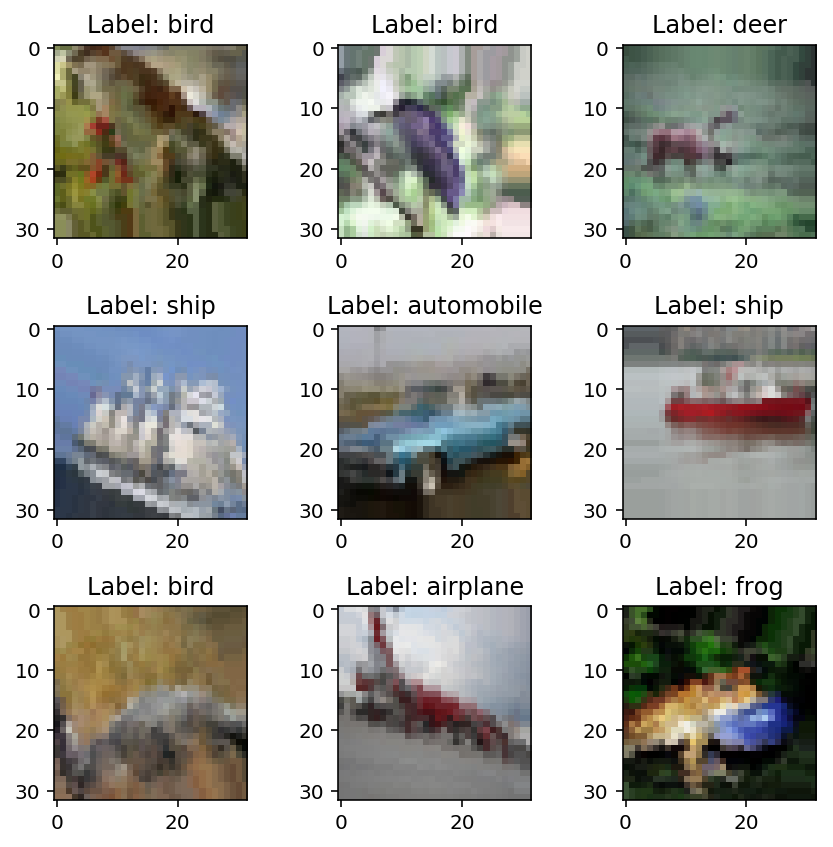

In [16]:
helper.display_data_augmentation(gen, x_test, y_val_test)

In [17]:
batch_size = 128
batches = gen.flow(x_train, y_train, batch_size)
test_batches = gen.flow(x_test, y_test, batch_size)
steps_per_epoch = batches.n // batch_size
validation_steps = test_batches.n // batch_size

In [18]:
global_history = model.fit_generator(batches,
                                     steps_per_epoch=steps_per_epoch,
                                     epochs=1,
                                     validation_data=test_batches,
                                     validation_steps=validation_steps,
                                     verbose=2, 
                                     callbacks=[checkpoint])

Epoch 1/1
44s - loss: 1.8403 - acc: 0.3066 - val_loss: 1.5734 - val_acc: 0.4091


In [19]:
model.save_weights(model_path+'cifar10_epoch1.h5')

In [20]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=9,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=2,
                                      callbacks=[checkpoint])

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/9
43s - loss: 1.4920 - acc: 0.4486 - val_loss: 1.3739 - val_acc: 0.4911
Epoch 2/9
42s - loss: 1.3412 - acc: 0.5106 - val_loss: 1.2684 - val_acc: 0.5366
Epoch 3/9
42s - loss: 1.2379 - acc: 0.5536 - val_loss: 1.2382 - val_acc: 0.5616
Epoch 4/9
42s - loss: 1.1746 - acc: 0.5799 - val_loss: 1.1543 - val_acc: 0.5866
Epoch 5/9
42s - loss: 1.1201 - acc: 0.6004 - val_loss: 1.0976 - val_acc: 0.6012
Epoch 6/9
42s - loss: 1.0668 - acc: 0.6220 - val_loss: 1.0115 - val_acc: 0.6441
Epoch 7/9
42s - loss: 1.0432 - acc: 0.6311 - val_loss: 0.9527 - val_acc: 0.6650
Epoch 8/9
42s - loss: 1.0079 - acc: 0.6441 - val_loss: 0.9394 - val_acc: 0.6604
Epoch 9/9
42s - loss: 0.9841 - acc: 0.6545 - val_loss: 0.9290 - val_acc: 0.6754


In [21]:
model.save_weights(model_path+'cifar10_epoch10.h5')

In [22]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=40,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=2,
                                      callbacks=[checkpoint])

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/40
42s - loss: 0.9662 - acc: 0.6557 - val_loss: 0.9127 - val_acc: 0.6801
Epoch 2/40
42s - loss: 0.9405 - acc: 0.6681 - val_loss: 0.9228 - val_acc: 0.6825
Epoch 3/40
42s - loss: 0.9180 - acc: 0.6783 - val_loss: 0.8938 - val_acc: 0.6891
Epoch 4/40
42s - loss: 0.9014 - acc: 0.6828 - val_loss: 0.8727 - val_acc: 0.6974
Epoch 5/40
44s - loss: 0.8928 - acc: 0.6871 - val_loss: 0.8590 - val_acc: 0.6961
Epoch 6/40
42s - loss: 0.8832 - acc: 0.6896 - val_loss: 0.8295 - val_acc: 0.7110
Epoch 7/40
42s - loss: 0.8658 - acc: 0.6979 - val_loss: 0.8151 - val_acc: 0.7163
Epoch 8/40
42s - loss: 0.8672 - acc: 0.6973 - val_loss: 0.8447 - val_acc: 0.7013
Epoch 9/40
42s - loss: 0.8517 - acc: 0.7008 - val_loss: 0.8068 - val_acc: 0.7164
Epoch 10/40
42s - loss: 0.8378 - acc: 0.7065 - val_loss: 0.8027 - val_acc: 0.7174
Epoch 11/40
42s - loss: 0.8293 - acc: 0.7130 - val_loss: 0.7742 - val_acc: 0.7298
Epoch 12/40
42s - loss: 0.8281 - acc: 0.7110 - val_loss: 0.7805 - val_acc: 0.7291
Epoch 13/40
42s - loss: 0

In [23]:
model.save_weights(model_path+'cifar10_epoch50.h5')

In [24]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=50,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=2,
                                      callbacks=[checkpoint])

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/50
42s - loss: 0.6915 - acc: 0.7617 - val_loss: 0.6667 - val_acc: 0.7761
Epoch 2/50
42s - loss: 0.6820 - acc: 0.7678 - val_loss: 0.6762 - val_acc: 0.7732
Epoch 3/50
42s - loss: 0.6888 - acc: 0.7626 - val_loss: 0.6599 - val_acc: 0.7756
Epoch 4/50
42s - loss: 0.6845 - acc: 0.7648 - val_loss: 0.6744 - val_acc: 0.7711
Epoch 5/50
42s - loss: 0.6836 - acc: 0.7639 - val_loss: 0.6609 - val_acc: 0.7747
Epoch 6/50
42s - loss: 0.6801 - acc: 0.7649 - val_loss: 0.6629 - val_acc: 0.7775
Epoch 7/50
42s - loss: 0.6764 - acc: 0.7661 - val_loss: 0.6807 - val_acc: 0.7650
Epoch 8/50
42s - loss: 0.6789 - acc: 0.7690 - val_loss: 0.6640 - val_acc: 0.7694
Epoch 9/50
42s - loss: 0.6769 - acc: 0.7641 - val_loss: 0.6968 - val_acc: 0.7673
Epoch 10/50
42s - loss: 0.6697 - acc: 0.7705 - val_loss: 0.6601 - val_acc: 0.7763
Epoch 11/50
42s - loss: 0.6634 - acc: 0.7742 - val_loss: 0.6641 - val_acc: 0.7728
Epoch 12/50
42s - loss: 0.6691 - acc: 0.7703 - val_loss: 0.6554 - val_acc: 0.7810
Epoch 13/50
42s - loss: 0

In [25]:
model.save_weights(model_path+'cifar10_epoch100.h5')

In [26]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=50,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=2,
                                      callbacks=[checkpoint])

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/50
42s - loss: 0.5942 - acc: 0.7965 - val_loss: 0.6104 - val_acc: 0.7960
Epoch 2/50
42s - loss: 0.5976 - acc: 0.7967 - val_loss: 0.6097 - val_acc: 0.7965
Epoch 3/50
42s - loss: 0.5949 - acc: 0.7950 - val_loss: 0.5980 - val_acc: 0.7998
Epoch 4/50
42s - loss: 0.5985 - acc: 0.7938 - val_loss: 0.5951 - val_acc: 0.7924
Epoch 5/50
42s - loss: 0.5897 - acc: 0.7987 - val_loss: 0.6063 - val_acc: 0.7927
Epoch 6/50
42s - loss: 0.5909 - acc: 0.7976 - val_loss: 0.5837 - val_acc: 0.8059
Epoch 7/50
42s - loss: 0.5873 - acc: 0.7994 - val_loss: 0.5878 - val_acc: 0.8054
Epoch 8/50
42s - loss: 0.5909 - acc: 0.7993 - val_loss: 0.6004 - val_acc: 0.7943
Epoch 9/50
42s - loss: 0.5848 - acc: 0.8011 - val_loss: 0.5816 - val_acc: 0.8013
Epoch 10/50
42s - loss: 0.5900 - acc: 0.7979 - val_loss: 0.5814 - val_acc: 0.8013
Epoch 11/50
42s - loss: 0.5840 - acc: 0.7998 - val_loss: 0.5885 - val_acc: 0.8038
Epoch 12/50
42s - loss: 0.5876 - acc: 0.8005 - val_loss: 0.5879 - val_acc: 0.8049
Epoch 13/50
42s - loss: 0

In [27]:
model.save_weights(model_path+'cifar10_epoch150.h5')

In [28]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=100,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=2,
                                      callbacks=[checkpoint])

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/100
42s - loss: 0.5519 - acc: 0.8123 - val_loss: 0.5373 - val_acc: 0.8197
Epoch 2/100
43s - loss: 0.5506 - acc: 0.8127 - val_loss: 0.5307 - val_acc: 0.8167
Epoch 3/100
42s - loss: 0.5569 - acc: 0.8103 - val_loss: 0.5681 - val_acc: 0.8120
Epoch 4/100
42s - loss: 0.5457 - acc: 0.8154 - val_loss: 0.5636 - val_acc: 0.8103
Epoch 5/100
42s - loss: 0.5441 - acc: 0.8132 - val_loss: 0.5687 - val_acc: 0.8082
Epoch 6/100
42s - loss: 0.5499 - acc: 0.8122 - val_loss: 0.5560 - val_acc: 0.8176
Epoch 7/100
42s - loss: 0.5458 - acc: 0.8136 - val_loss: 0.5698 - val_acc: 0.8101
Epoch 8/100
42s - loss: 0.5565 - acc: 0.8109 - val_loss: 0.5573 - val_acc: 0.8167
Epoch 9/100
42s - loss: 0.5492 - acc: 0.8151 - val_loss: 0.5787 - val_acc: 0.8023
Epoch 10/100
42s - loss: 0.5495 - acc: 0.8119 - val_loss: 0.5706 - val_acc: 0.8067
Epoch 11/100
42s - loss: 0.5450 - acc: 0.8156 - val_loss: 0.5632 - val_acc: 0.8142
Epoch 12/100
42s - loss: 0.5511 - acc: 0.8143 - val_loss: 0.5584 - val_acc: 0.8139
Epoch 13/100


42s - loss: 0.5204 - acc: 0.8268 - val_loss: 0.5442 - val_acc: 0.8228


In [29]:
model.save_weights(model_path+'cifar10_epoch250.h5')

In [31]:
model.load_weights(model_path+'best_model.h5')

### Testing accuracy on test dataset:

In [32]:
score = model.evaluate(x_test, y_test, verbose=1)
print("\n")
print("Accuracy :", score[1])
print("Loss     :", score[0])

10000/10000 [==============================] - 3s     


Accuracy : 0.873
Loss     : 0.381089244711


### Displaying number of correct and incorrect predictions:

In [33]:
predicted_labels = model.predict_classes(x_test)

# have to make new array cause y_val_test has different structure
y_val_parsed = []
for element in y_val_test:
    y_val_parsed.append(element[0])

correct = np.nonzero(predicted_labels == y_val_parsed)[0]
incorrect = np.nonzero(predicted_labels != y_val_parsed)[0]

print("\n")
print(" Number of correct predictions   : {}/{}".format(len(correct), len(predicted_labels)))
print(" Number of incorrect predictions : {}/{}".format(len(incorrect), len(predicted_labels)))

 9984/10000 [============================>.] - ETA: 0s

 Number of correct predictions   : 8730/10000
 Number of incorrect predictions : 1270/10000


### Random correct predictions:

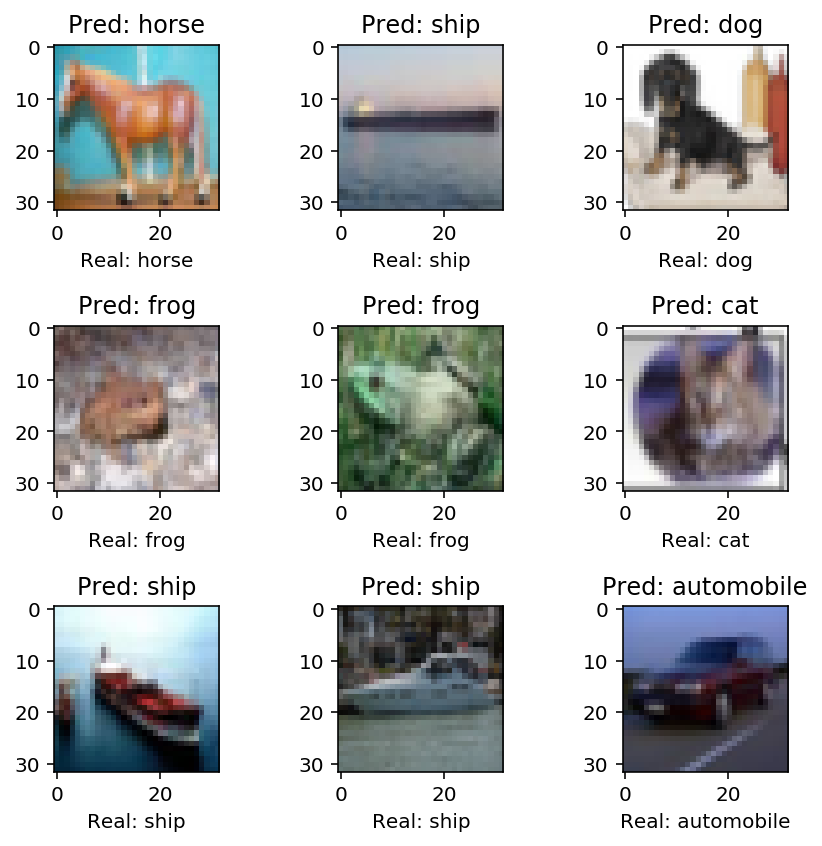

In [34]:
helper.display_nine_random_predictions(predicted_labels, correct, x_test, y_val_test)

### Random incorrect predictions:

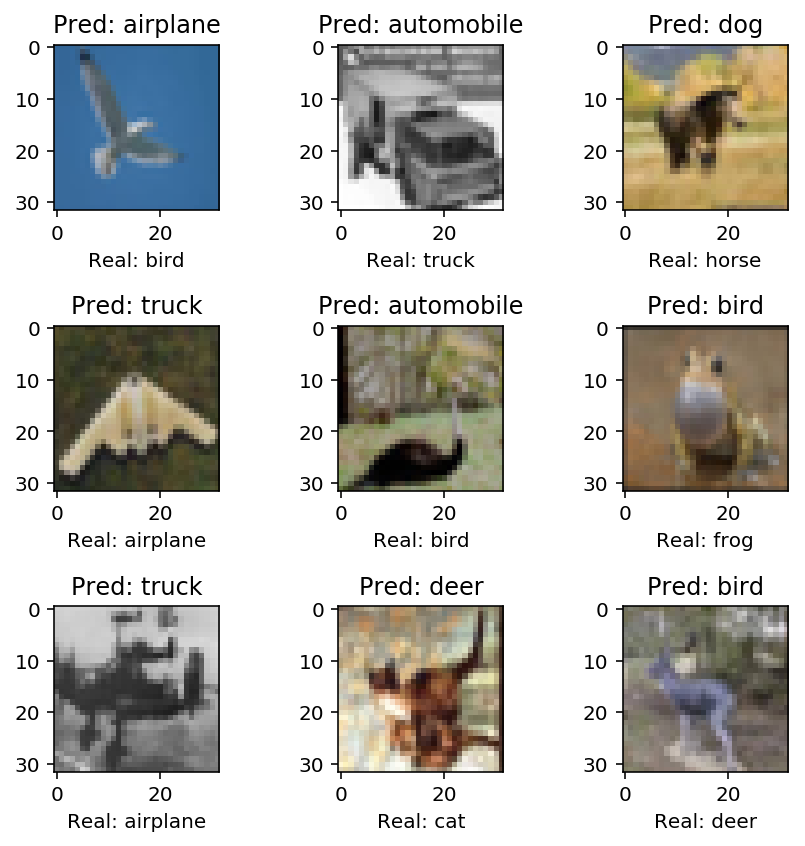

In [36]:
helper.display_nine_random_predictions(predicted_labels, incorrect, x_test, y_val_test)

### Training stats:

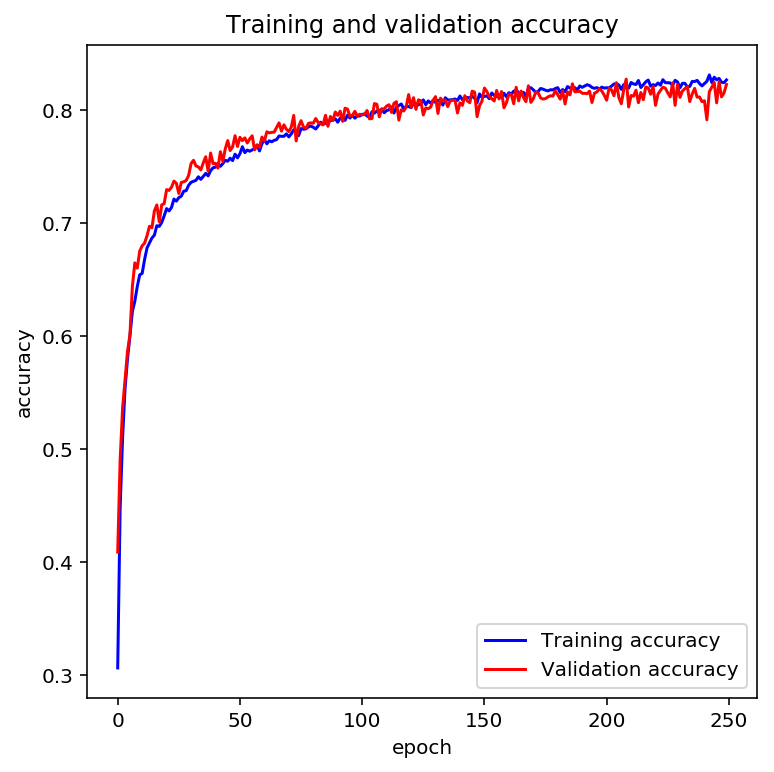

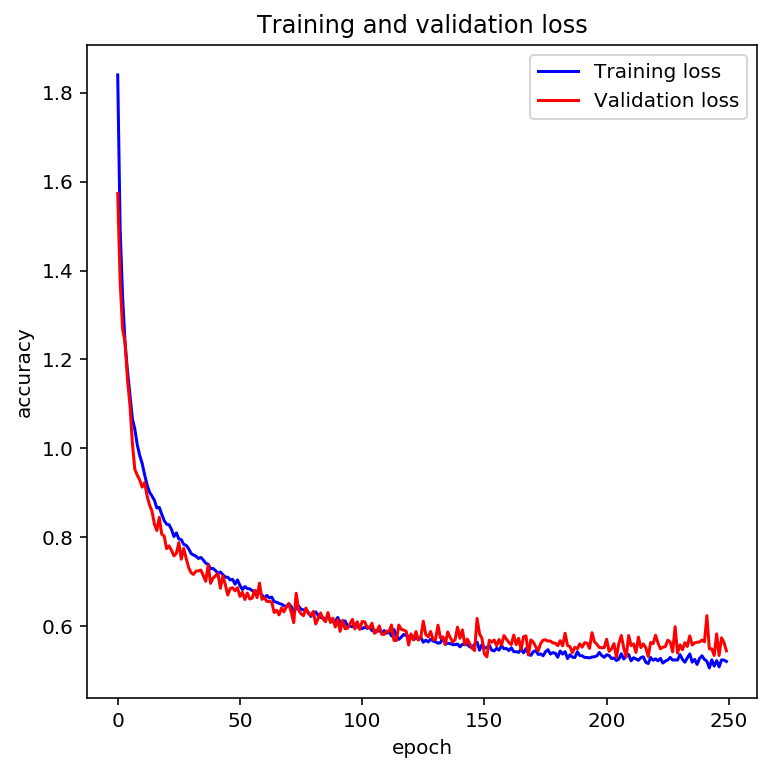

In [37]:
helper.display_accuracy_and_loss(global_history)

### Displaying 4 random wrong predictions with probabilities

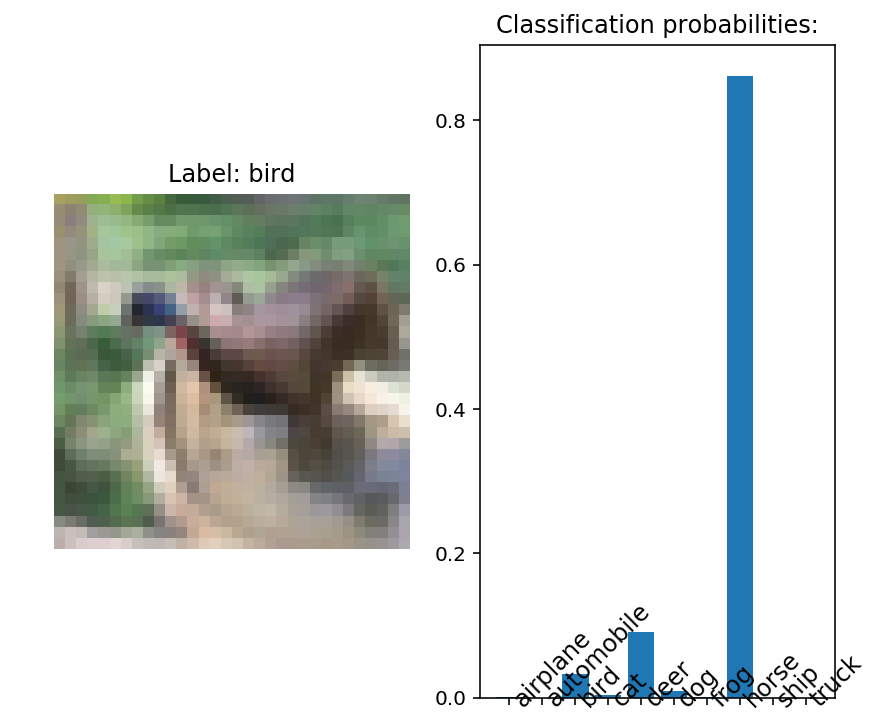

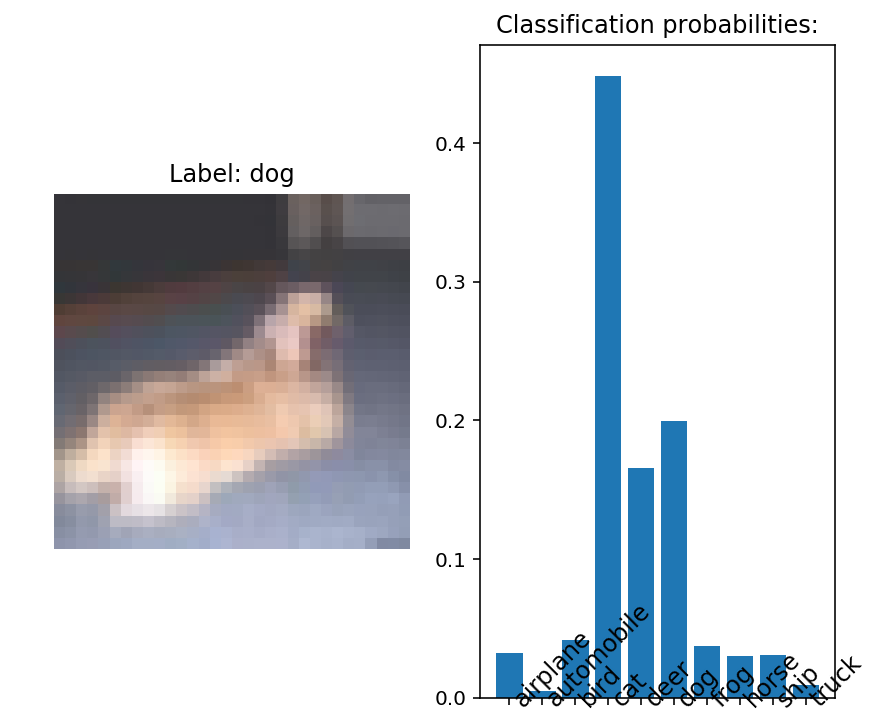

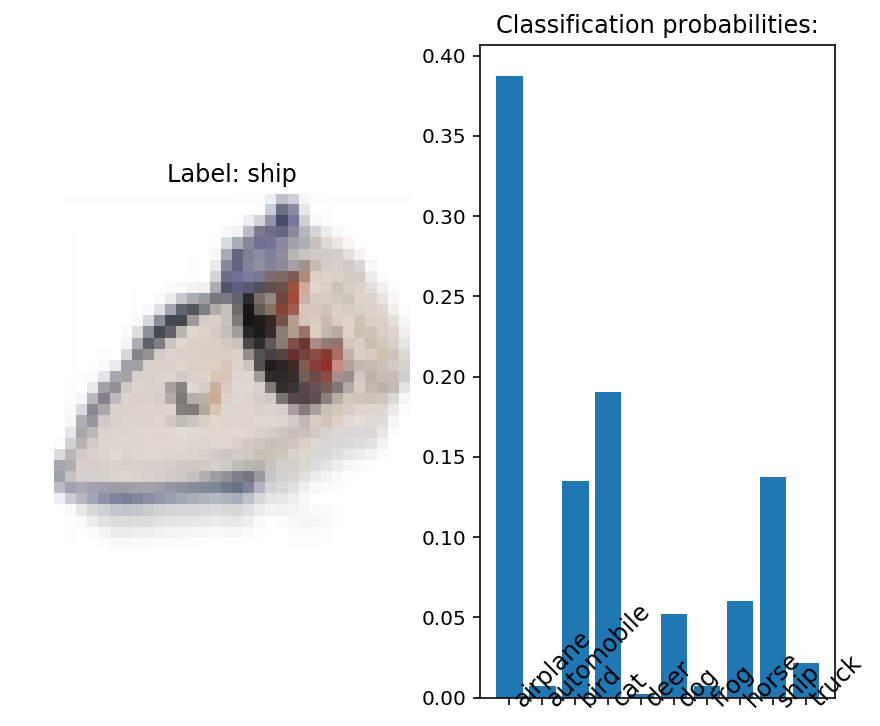

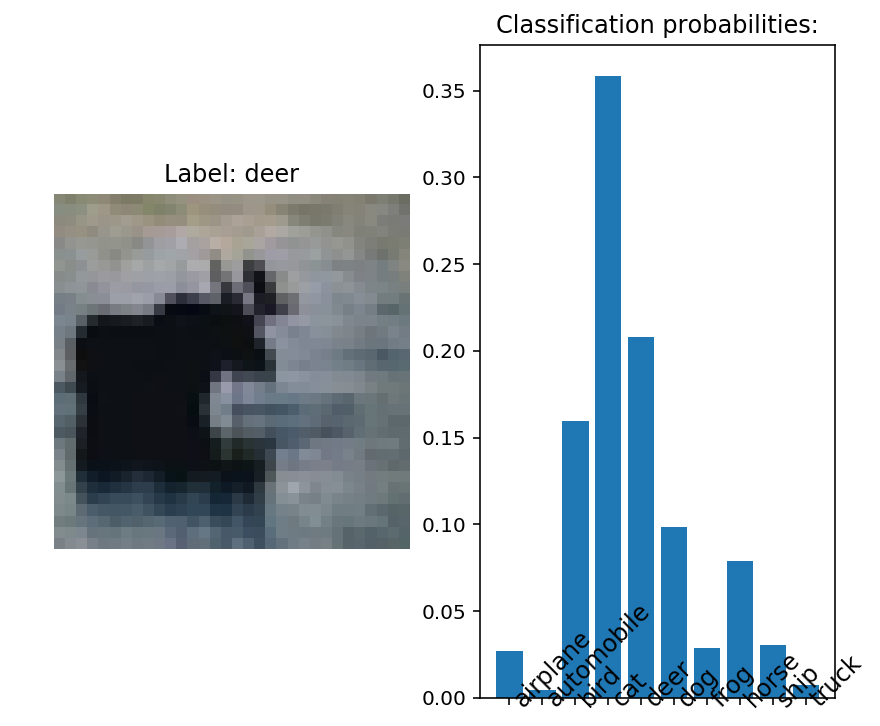

In [39]:
helper.display_incorect_with_probabilities(model, incorrect, x_test, y_val_test, 4)